## üéØ Objetivo
##### Entrenar un modelo de predicci√≥n de calor√≠as quemadas por sesi√≥n para cada uno de los 5 clusters que obtuviste con KMeans. Esto nos permite que cada modelo se adapte al perfil de usuario representado en su cluster, mejorando la precisi√≥n respecto a usar un solo modelo general.

### Paso 1. Cargar dataset con los clusters asignados

* __train_test_split__ divide los datos en entrenamiento y prueba.

* __LinearRegression__ y __RandomForestRegressor__ son los modelos a comparar.

* __mean_squared_error__ y __r2_score__ son m√©tricas para evaluar los resultados.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Cargar el dataset
dataset = pd.read_csv("dataset_con_clusters.csv")

# Verificar columnas
print(dataset.columns,"\n")

print("Clusters encontrados:", dataset['cluster'].unique())
dataset['cluster'].value_counts(normalize=True)


Index(['id', 'Age', 'Gender', 'Weight (kg)', 'Height (m)', 'Max_BPM',
       'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)', 'Calories_Burned',
       'Fat_Percentage', 'Water_Intake (liters)',
       'Workout_Frequency (days/week)', 'Experience_Level', 'BMI',
       'Workout_Cardio', 'Workout_HIIT', 'Workout_Strength', 'Workout_Yoga',
       'cluster'],
      dtype='object') 

Clusters encontrados: [0 1 2]


cluster
1    0.595067
0    0.202467
2    0.202467
Name: proportion, dtype: float64

### Preparar estructuras para modelos por cluster

In [13]:
clusters = dataset['cluster'].unique()
modelos_por_cluster = {}
resultados = {}

### Entrenar un modelo por cluster

In [14]:
modelos = {
    "Regresi√≥n Lineal": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

resultados = {}

for cl in sorted(dataset['cluster'].unique()):
    df_cl = dataset[dataset['cluster'] == cl]
    
    X = df_cl.drop(columns=['id', 'Calories_Burned', 'cluster'])
    columnas_entrenamiento = X.columns.tolist()
    joblib.dump(columnas_entrenamiento, f'columns_cluster_{cl}.pkl')


    y = df_cl['Calories_Burned']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    resultados[cl] = {}
    
    for nombre, modelo in modelos.items():
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        
        resultados[cl][nombre] = {
            "modelo": modelo,
            "R2": r2_score(y_test, y_pred),
            "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
            "y_test": y_test,
            "y_pred": y_pred
        }


### Mostrar m√©tricas por cluster

In [15]:
print("\nR¬≤ Score: mide qu√© tanto del valor de y se puede explicar con X (ideal cercano a 1).\nRMSE: mide el error promedio entre las predicciones y los valores reales (m√°s bajo = mejor).")

for cl in resultados:
    print(f"\n # Resultados del Cluster {cl}")
    for nombre in modelos:
        r2 = resultados[cl][nombre]['R2']
        rmse = resultados[cl][nombre]['RMSE']
        print(f"  {nombre:>18} | R¬≤ = {r2:.4f} | RMSE = {rmse:.2f}")



R¬≤ Score: mide qu√© tanto del valor de y se puede explicar con X (ideal cercano a 1).
RMSE: mide el error promedio entre las predicciones y los valores reales (m√°s bajo = mejor).

 # Resultados del Cluster 0
    Regresi√≥n Lineal | R¬≤ = 0.9689 | RMSE = 36.20
       Random Forest | R¬≤ = 0.8858 | RMSE = 69.41
   Gradient Boosting | R¬≤ = 0.9605 | RMSE = 40.80

 # Resultados del Cluster 1
    Regresi√≥n Lineal | R¬≤ = 0.9828 | RMSE = 26.74
       Random Forest | R¬≤ = 0.9484 | RMSE = 46.36
   Gradient Boosting | R¬≤ = 0.9892 | RMSE = 21.16

 # Resultados del Cluster 2
    Regresi√≥n Lineal | R¬≤ = 0.9828 | RMSE = 30.18
       Random Forest | R¬≤ = 0.9767 | RMSE = 35.08
   Gradient Boosting | R¬≤ = 0.9914 | RMSE = 21.36


### Visualizar predicci√≥n vs real por cluster

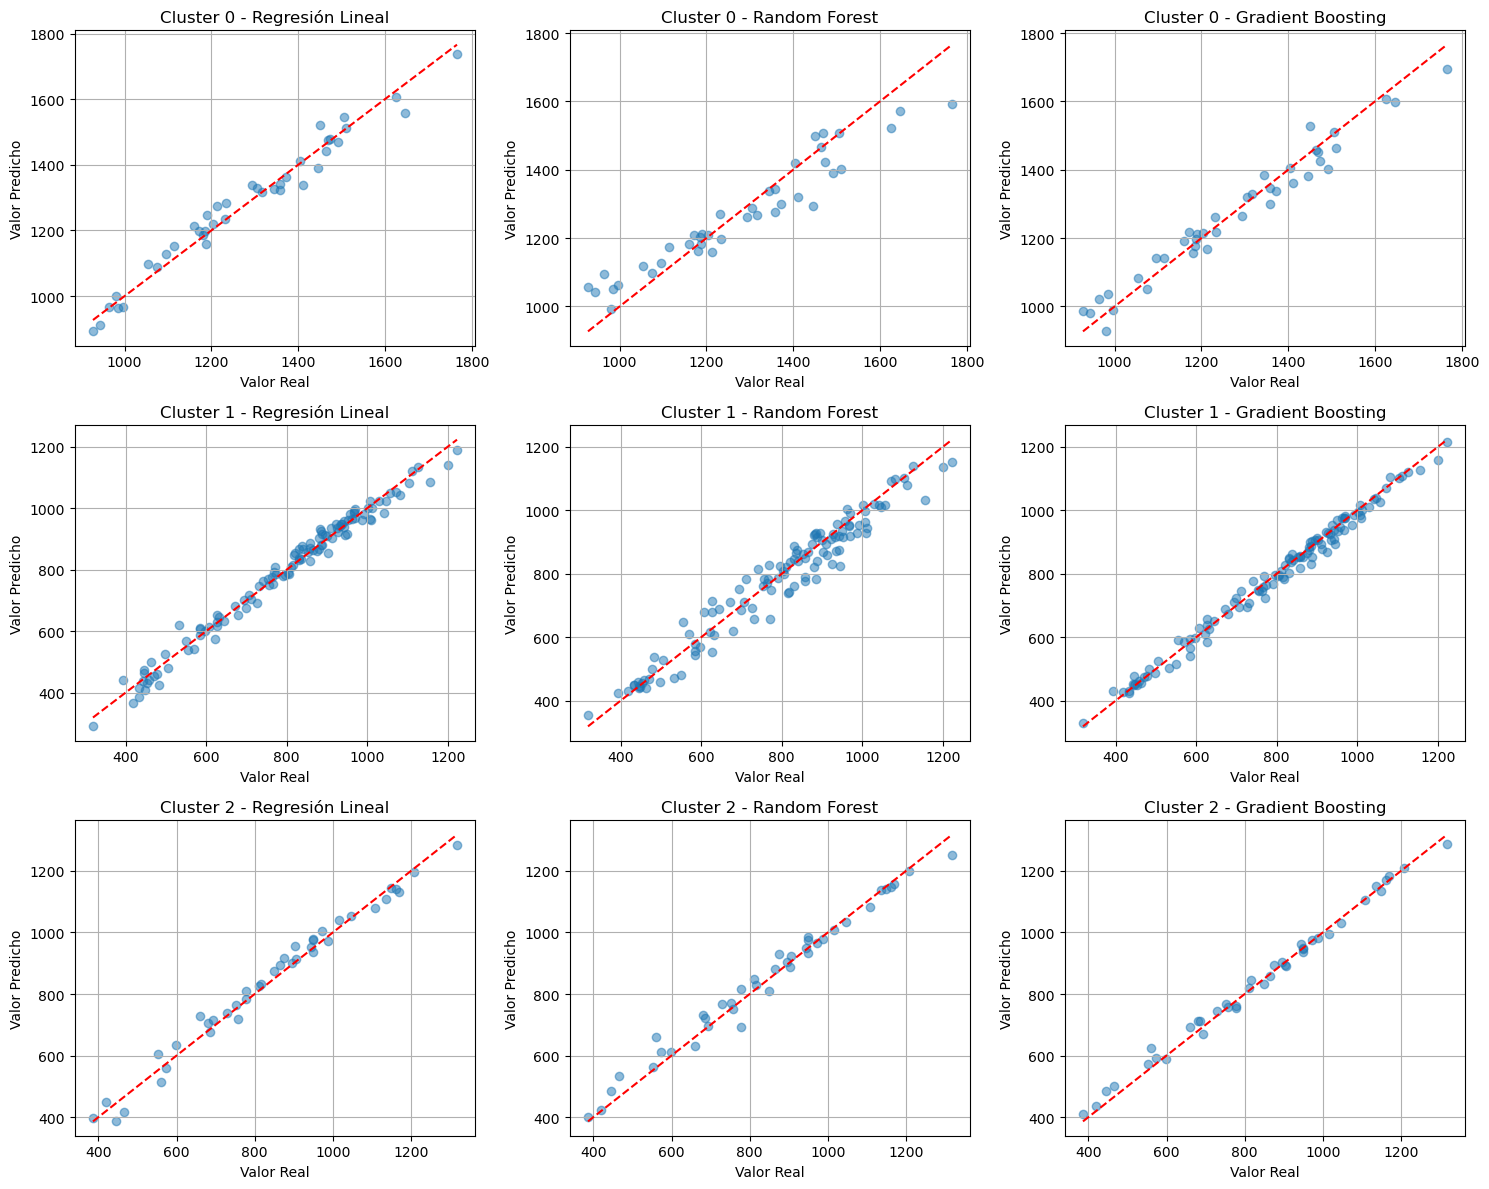

In [16]:
import matplotlib.pyplot as plt

# Lista de modelos en orden fijo
modelo_nombres = ["Regresi√≥n Lineal", "Random Forest", "Gradient Boosting"]
clusters_ordenados = sorted(resultados.keys())

# Crear figura y subplots
n_clusters = len(clusters_ordenados)
n_modelos = len(modelo_nombres)

fig, axes = plt.subplots(n_clusters, n_modelos, figsize=(n_modelos * 5, n_clusters * 4))

for i, cl in enumerate(clusters_ordenados):
    for j, modelo in enumerate(modelo_nombres):
        ax = axes[i, j] if n_clusters > 1 else axes[j]  # manejar caso de solo 1 cluster

        y_test = resultados[cl][modelo]['y_test']
        y_pred = resultados[cl][modelo]['y_pred']

        ax.scatter(y_test, y_pred, alpha=0.5)
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
                color='red', linestyle='--')
        ax.set_title(f'Cluster {cl} - {modelo}')
        ax.set_xlabel("Valor Real")
        ax.set_ylabel("Valor Predicho")
        ax.grid(True)

plt.tight_layout()
plt.show()


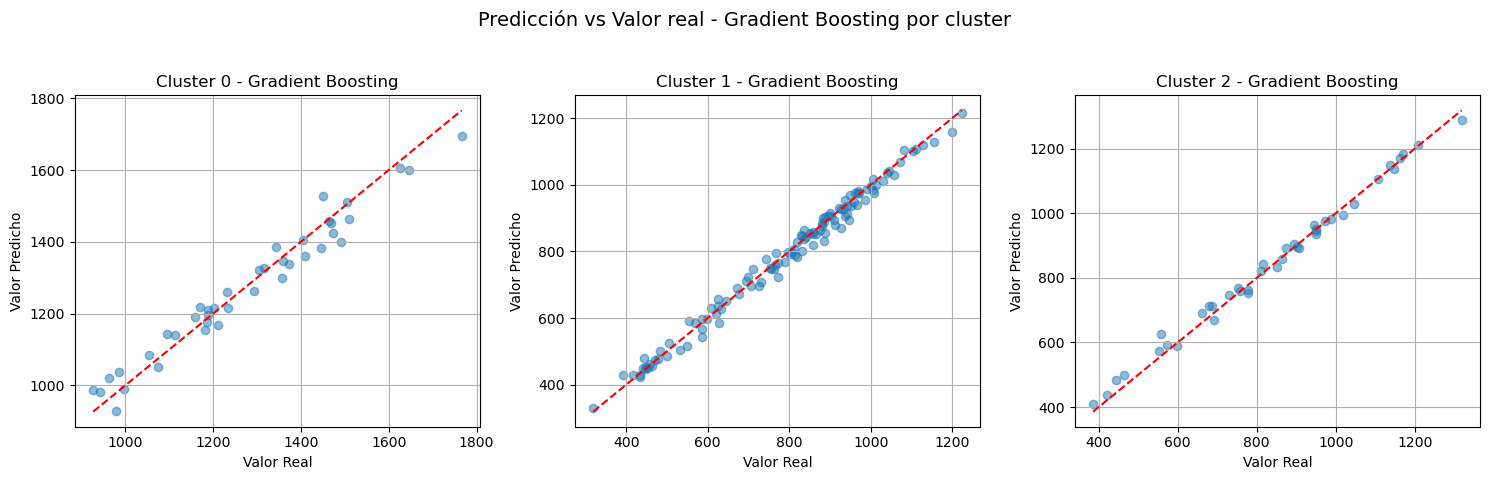

In [17]:
import matplotlib.pyplot as plt

# Lista de clusters ordenados
clusters_ordenados = sorted(resultados.keys())
n_clusters = len(clusters_ordenados)

# Crear figura con una sola fila y una columna por cluster
fig, axes = plt.subplots(1, n_clusters, figsize=(n_clusters * 5, 5))

# Asegurar que 'axes' sea iterable aunque haya solo un cluster
if n_clusters == 1:
    axes = [axes]

# Iterar por cada cluster y generar solo la gr√°fica de Gradient Boosting
for i, cl in enumerate(clusters_ordenados):
    ax = axes[i]
    y_test = resultados[cl]["Gradient Boosting"]['y_test']
    y_pred = resultados[cl]["Gradient Boosting"]['y_pred']

    ax.scatter(y_test, y_pred, alpha=0.5)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
            color='red', linestyle='--')
    ax.set_title(f'Cluster {cl} - Gradient Boosting')
    ax.set_xlabel("Valor Real")
    ax.set_ylabel("Valor Predicho")
    ax.grid(True)

plt.suptitle("Predicci√≥n vs Valor real - Gradient Boosting por cluster", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [18]:
# Construir tabla resumen
resumen = []

for cl in sorted(resultados.keys()):
    for modelo in ["Regresi√≥n Lineal", "Random Forest", "Gradient Boosting"]:
        r2 = resultados[cl][modelo]['R2']
        rmse = resultados[cl][modelo]['RMSE']
        resumen.append({
            'Cluster': cl,
            'Modelo': modelo,
            'R¬≤': round(r2, 4),
            'RMSE': round(rmse, 2)
        })

tabla_resumen = pd.DataFrame(resumen)

# Mostrar resultados ordenados por cluster
tabla_resumen.sort_values(by=['Cluster', 'Modelo'])

# Identificar el mejor modelo por R¬≤ dentro de cada cluster
mejores = tabla_resumen.loc[tabla_resumen.groupby('Cluster')['R¬≤'].idxmax()]
print("üèÖ Mejores modelos por cluster:")
print(mejores)


üèÖ Mejores modelos por cluster:
   Cluster             Modelo      R¬≤   RMSE
0        0   Regresi√≥n Lineal  0.9689  36.20
5        1  Gradient Boosting  0.9892  21.16
8        2  Gradient Boosting  0.9914  21.36


## üéØ Objetivo:
##### Dado un nuevo registro (una nueva sesi√≥n), identifique su cluster y luego use el modelo √≥ptimo correspondiente para predecir las calor√≠as quemadas.

In [19]:
import joblib
scaler = joblib.load("scaler.pkl")
kmeans = joblib.load("kmeans.pkl")

# Guardar solo el mejor modelo por cluster
for cl, datos in resultados.items():
    mejor_modelo = max(datos.items(), key=lambda x: x[1]['R2'])[0]
    print(f"üìå Cluster {cl} ‚Üí modelo seleccionado: {mejor_modelo}")
    joblib.dump(datos[mejor_modelo]['modelo'], f'model_cluster_{cl}.pkl')

üìå Cluster 0 ‚Üí modelo seleccionado: Regresi√≥n Lineal
üìå Cluster 1 ‚Üí modelo seleccionado: Gradient Boosting
üìå Cluster 2 ‚Üí modelo seleccionado: Gradient Boosting


#### Funci√≥n para predecir calor√≠as en producci√≥n

In [20]:
def predecir_calorias(nuevos_datos_df):
    import joblib

    # Cargar objetos de clustering
    scaler = joblib.load('scaler.pkl')
    kmeans = joblib.load('kmeans.pkl')

    # Filtrar columnas para clustering
    columnas_clustering = [
        'Age', 'Weight (kg)', 'Height (m)', 'BMI',
        'Fat_Percentage', 'Experience_Level', 'Workout_Frequency (days/week)'
    ]
    X_cluster = nuevos_datos_df[columnas_clustering]
    X_scaled = scaler.transform(X_cluster)
    cluster = kmeans.predict(X_scaled)[0]

    # Cargar modelo y columnas esperadas para ese cluster
    modelo = joblib.load(f'model_cluster_{cluster}.pkl')
    columnas_entrenamiento = joblib.load(f'columns_cluster_{cluster}.pkl')

    # Reordenar y filtrar las columnas para predicci√≥n
    X_final = nuevos_datos_df[columnas_entrenamiento]
    prediccion = modelo.predict(X_final)[0]

    return cluster, prediccion


#### Ejemplo: Nuevo usuario

In [21]:
nuevo_usuario = pd.DataFrame([{
    'Age': 30,
    'Gender': 1,
    'Weight (kg)': 75,
    'Height (m)': 1.75,
    'BMI': 24.5,
    'Fat_Percentage': 22,
    'Experience_Level': 2,
    'Workout_Frequency (days/week)': 4,
    'Workout_Cardio': 1,
    'Workout_HIIT': 0,
    'Workout_Strength': 1,
    'Workout_Yoga': 0,
    'Water_Intake (liters)': 2.0,
    'Max_BPM': 180,
    'Avg_BPM': 145,
    'Resting_BPM': 70,
    'Session_Duration (hours)': 1.2
}])


cluster, pred = predecir_calorias(nuevo_usuario)
print(f"‚û°Ô∏è Cluster asignado: {cluster}")
print(f"üî• Calor√≠as estimadas: {pred:.2f}")


‚û°Ô∏è Cluster asignado: 1
üî• Calor√≠as estimadas: 924.79


In [22]:
nuevo_usuario2 = pd.DataFrame([{
    'Age': 24,
    'Gender': 1,
    'Weight (kg)': 63,
    'Height (m)': 1.70,
    'BMI': 21.8,
    'Fat_Percentage': 23,
    'Experience_Level': 2,
    'Workout_Frequency (days/week)': 4,
    'Workout_Cardio': 1,
    'Workout_HIIT': 0,
    'Workout_Strength': 1,
    'Workout_Yoga': 0,
    'Water_Intake (liters)': 2.2,
    'Max_BPM': 185,
    'Avg_BPM': 150,
    'Resting_BPM': 65,
    'Session_Duration (hours)': 1.1
}])

cluster, pred = predecir_calorias(nuevo_usuario2)
print(f"‚û°Ô∏è Cluster asignado: {cluster}")
print(f"üî• Calor√≠as estimadas: {pred:.2f}")

‚û°Ô∏è Cluster asignado: 1
üî• Calor√≠as estimadas: 897.78


In [23]:
nuevo_usuario3 = pd.DataFrame([{
    'Age': 38,
    'Gender': 0,
    'Weight (kg)': 112,
    'Height (m)': 1.78,
    'BMI': 35.3,
    'Fat_Percentage': 28,
    'Experience_Level': 1,
    'Workout_Frequency (days/week)': 2,
    'Workout_Cardio': 1,
    'Workout_HIIT': 0,
    'Workout_Strength': 0,
    'Workout_Yoga': 0,
    'Water_Intake (liters)': 1.2,
    'Max_BPM': 160,
    'Avg_BPM': 130,
    'Resting_BPM': 80,
    'Session_Duration (hours)': 0.9
}])

cluster, pred = predecir_calorias(nuevo_usuario3)
print(f"‚û°Ô∏è Cluster asignado: {cluster}")
print(f"üî• Calor√≠as estimadas: {pred:.2f}")

‚û°Ô∏è Cluster asignado: 2
üî• Calor√≠as estimadas: 659.28


In [24]:
nuevo_usuario4 = pd.DataFrame([{
    'Age': 26,
    'Gender': 0,
    'Weight (kg)': 60,
    'Height (m)': 1.67,
    'BMI': 21.8,
    'Fat_Percentage': 26.8,
    'Experience_Level': 1,
    'Workout_Frequency (days/week)': 3,
    'Workout_Cardio': 1,
    'Workout_HIIT': 0,
    'Workout_Strength': 0,
    'Workout_Yoga': 1,
    'Water_Intake (liters)': 1.5,
    'Max_BPM': 160,
    'Avg_BPM': 135,
    'Resting_BPM': 75,
    'Session_Duration (hours)': 0.9
}])

cluster, pred = predecir_calorias(nuevo_usuario4)
print(f"‚û°Ô∏è Cluster asignado: {cluster}")
print(f"üî• Calor√≠as estimadas: {pred:.2f}")

‚û°Ô∏è Cluster asignado: 1
üî• Calor√≠as estimadas: 675.75


In [25]:
nuevo_usuario5 = pd.DataFrame([{
    'Age': 39.0,                      
    'Gender': 1,                      
    'Weight (kg)': 74.5,              
    'Height (m)': 1.71,               
    'BMI': 25.5,                      
    'Fat_Percentage': 15.2,           
    'Experience_Level': 3,            
    'Workout_Frequency (days/week)': 4.7,  
    'Workout_Cardio': 1,              
    'Workout_HIIT': 0,                
    'Workout_Strength': 1,            
    'Workout_Yoga': 0,                
    'Water_Intake (liters)': 2.1,     
    'Max_BPM': 178,                   
    'Avg_BPM': 147,                   
    'Resting_BPM': 67,                
    'Session_Duration (hours)': 1.15  
}])

cluster, pred = predecir_calorias(nuevo_usuario5)
print(f"‚û°Ô∏è Cluster asignado: {cluster}")
print(f"üî• Calor√≠as estimadas: {pred:.2f}")


‚û°Ô∏è Cluster asignado: 0
üî• Calor√≠as estimadas: 899.00


In [26]:
usuario_comparativo = pd.DataFrame([{
    'Age': 35,
    'Gender': 1,
    'Weight (kg)': 85,
    'Height (m)': 1.80,
    'BMI': 26.2,
    'Fat_Percentage': 20,
    'Experience_Level': 2,
    'Workout_Frequency (days/week)': 3,
    'Workout_Cardio': 1,
    'Workout_HIIT': 1,
    'Workout_Strength': 1,
    'Workout_Yoga': 0,
    'Water_Intake (liters)': 1.8,
    'Max_BPM': 172,
    'Avg_BPM': 138,
    'Resting_BPM': 68,
    'Session_Duration (hours)': 1.0
}])

cluster, pred = predecir_calorias(usuario_comparativo)
print(f"ESCENARIO A")
print(f"‚û°Ô∏è Cluster asignado: {cluster}")
print(f"üî• Calor√≠as estimadas: {pred:.2f}")

ESCENARIO A
‚û°Ô∏è Cluster asignado: 2
üî• Calor√≠as estimadas: 729.15


## üü¶ COMPARATIVA DEL MISMO USUARIO DEL DATASET CON ESCENARIO B

In [27]:
# Seleccionar un usuario (puede ser el primero del dataset)
usuario_real = dataset.iloc[1].copy()

# Guardar las calor√≠as reales para comparar despu√©s
calorias_reales = usuario_real['Calories_Burned']

# Mostrar datos del usuario
print(usuario_real)
print(f"üî• Calor√≠as reales: {calorias_reales:.2f}")


id                                 2.00
Age                               46.00
Gender                             0.00
Weight (kg)                       74.90
Height (m)                         1.53
Max_BPM                          179.00
Avg_BPM                          151.00
Resting_BPM                       66.00
Session_Duration (hours)           1.30
Calories_Burned                  883.00
Fat_Percentage                    33.90
Water_Intake (liters)              2.10
Workout_Frequency (days/week)      4.00
Experience_Level                   2.00
BMI                               32.00
Workout_Cardio                     0.00
Workout_HIIT                       1.00
Workout_Strength                   0.00
Workout_Yoga                       0.00
cluster                            1.00
Name: 1, dtype: float64
üî• Calor√≠as reales: 883.00


In [28]:
# Crear DataFrame con una sola fila del usuario
usuario_df = pd.DataFrame([usuario_real])

# Eliminar la columna de calor√≠as si est√°
usuario_df = usuario_df.drop(columns=['Calories_Burned'])

# Usar la funci√≥n de predicci√≥n por cluster
cluster, pred_a = predecir_calorias(usuario_df)

print("‚û°Ô∏è Escenario A")
print(f"Cluster asignado: {cluster}")
print(f"‚≠ê Calor√≠as reales: {calorias_reales:.2f}")
print(f"üî• Calor√≠as estimadas: {pred_a:.2f}")
print(f"Diferencia de calorias::::", np.abs(calorias_reales - pred_a))


‚û°Ô∏è Escenario A
Cluster asignado: 1
‚≠ê Calor√≠as reales: 883.00
üî• Calor√≠as estimadas: 990.61
Diferencia de calorias:::: 107.60769208767795
